## Self made library

In [1]:
from matplotlib.pyplot import *
from numpy import *
from graphviz import Digraph
from IPython.display import Image,display
from sklearn.datasets import load_digits

g = Digraph("Network")
NodeCollection = []
Variables = []
counter = 0
dt = 0.01
class Node:
    name = None
    COLOR = "black"
    def __init__(self,name=None,draw=True):
        global counter,NodeCollection
        self.value = None
        self.outputNodes = []
        self.inputNodes = []
        self.id = counter
        self.draw = draw
        if self.name==None and name == None:
            self.name = "node "+str(self.id)
        elif name!=None:
            self.name = name
        if draw:
            g.node(str(self.id),self.name,color=self.COLOR)
        NodeCollection.append(self)
        counter += 1
    def __repr__(self):
        return f"name : {self.name}\n value : \n{self.value}\n grad : \n{self.grad}\n"
    def __add__(self,other):
        return Add([self,toNode(other)],"+")
    def __mul__(self,other):
        return Mul([self,toNode(other)],"*")
    def __pow__(self,other):
        return Pow([self,toNode(other)],"**")
    def __div__(self,other):
        return self*(other**(-1))
    def __neg__(self):
        return Neg([self],"-")
    def __sub__(self,other):
        return self + (-toNode(other))
    def recieve(self):
        self.grad = array([[0.0]],float64)
        for n in self.outputNodes:
            DFDX = n.dfdx_value[self.id]
            GRAD = n.grad
            #print("recievong from",n.id,"aka",n.name)
            #print("DFDX",DFDX.shape)
            #print("GRAD",GRAD.shape)
            if len(DFDX.shape)==1 and GRAD.shape==(1,DFDX.shape[0]) and len(self.value.shape)==2:
                self.grad = self.grad + GRAD.T @ DFDX[newaxis,:]
            elif DFDX.shape==(1,) or GRAD.shape ==(1,):
                self.grad = self.grad +  GRAD*DFDX
            else:
                #self.grad += dot(GRAD,DFDX)
                self.grad = self.grad + GRAD @ DFDX
class Function(Node):
    COLOR = "green"
    f = None
    dfdx = None
    dfdx_value = None
    def __init__(self,inputNodes,name=None,draw=True):
        super().__init__(name,draw)
        for n in inputNodes:
            if self.draw and n.draw:
                g.edge(str(n.id),str(self.id))
            n.outputNodes.append(self)
        self.inputNodes = inputNodes
        self.forward()
    def __repr__(self):
        return f"name : {self.name}\n value : \n{self.value}\n grad : \n{self.grad}\n dfdx : \n{self.dfdx_value}\n"
    def forward(self):
        self.inputs = dict([(node.id,node.value) for node in self.inputNodes])
        self.value = self.f(self.inputs)
        self.dfdx_value = self.dfdx(self.inputs)
        self.grad = array([[0.0]],float64)
    def backward(self):
        for n in self.inputNodes:
            n.recieve()
            n.backward()
class Variable(Node):
    COLOR = "red"
    def __init__(self,value,name=None,draw=True):
        super().__init__(name,draw)
        self.value = value
        self.grad = array([[0]],float64)
        Variables.append(self)
    def backward(self):
        pass
    def forward(self):
        global dt
        self.grad.resize(self.value.shape)
        self.value = self.value - self.grad*dt
class Constant(Variable):
    COLOR="black"
    def recieve(self):
        pass
    def forward(self):
        pass
def toNode(other,draw=True):
    name = None
    if isinstance(other,Node):
        return other
    if type(other) != ndarray:
        if type(other) != iterable:
            name = str(other)
            other = array([other]).astype(float64)
        else:
            other = array(other)
    return Constant(other,name,draw)
class Add(Function):
    name = "+"
    def f(self,inputs):
        S = 0.0
        for id in inputs:
            S = S + inputs[id]
        return S
    def dfdx(self,inputs):
        G = dict()
        for id in inputs:
            n = prod(inputs[id].shape)
            if n>1:
                G[id] = identity(n)
            else:
                G[id] = ones(prod(self.value.shape))[:,newaxis]
        return G
class Mul(Function):
    name = "*"
    def f(self,inputs):
        S = 1.0
        for id in inputs:
            S = S*inputs[id]
        return S
    def dfdx(self,inputs):
        G = dict()
        for id in inputs:
            S = 1.0
            for Id in inputs:
                if Id == id:
                    continue
                S = S*inputs[Id]
            S = S.flatten()
            n = prod(inputs[id].shape)
            if n > 1:
                m, = S.shape
                if m > 1:
                    S = diag(S)
                else :
                    S = S * identity(n)
            else:
                S = S[:,newaxis]
            G[id] = S
        return G
class Exp(Function):
    name = "exp"
    def f(self,inputs):
        return exp(next(iter(inputs.values())))
    def dfdx(self,inputs):
        id = next(iter(inputs.keys()))
        x = next(iter(inputs.values()))
        n = prod(x.shape)
        x = exp(x)
        x = x.flatten()
        if n>1:
            return {id:diagflat(x)}
        return {id:x[:,newaxis]}
class Pow(Function):
    name = "**"
    def f(self,inputs):
        x,n = inputs.values()
        return x**n
    def dfdx(self,inputs):
        ids = list(inputs.keys())
        x,n = inputs.values()
        m = prod(x.shape)
        if m > 1:
            return {ids[0]:diagflat(n*x**(n-1))}#,ids[1]:(log(x)*x**n).flatten()[:,newaxis]}
        return {ids[0]:(n*x**(n-1)).flatten()[:,newaxis]}#,ids[1]:(log(x)*x**n).flatten()[:,newaxis]}
class Neg(Function):
    name = "-"
    def f(self,inputs):
        return -next(iter(inputs.values()))
    def dfdx(self,inputs):
        id = next(iter(inputs.keys()))
        x = next(iter(inputs.values()))
        n = int(prod(x.shape))
        #if n>1:
        #    return {id:-identity(n)}
        #return {id:-array([1])}
        return {id:-identity(n)}
class Dot(Function):
    name = "."
    def f(self,inputs):
        x,y = inputs.values()
        d = dot(x,y)
        if len(d.shape)>0:
            return d
        return array([d])
    def dfdx(self,inputs):
        id1,id2 = inputs.keys()
        x,y = inputs.values()
        if len(x.shape) == 1:
            x = x[newaxis,:]
            y = y[newaxis,:]
        return {id1:y,id2:x}
class Sum(Function):
    name = "sum"
    def f(self,inputs):
        x, = inputs.values()
        if len(x.shape)==1:
            return array([sum(x)])
        else:
            return array([[sum(x)]])
    def dfdx(self,inputs):
        x, = inputs.values()
        id, = inputs.keys()
        s = x.shape
        if len(s)==1:
            return {id:ones((1,s[0]))}
        else :
            return {id:ones(s)}
class Sin(Function):
    name = "sin"
    def f(self,inputs):
        x, = inputs.values()
        return sin(x)
    def dfdx(self,inputs):
        x, = inputs.values()
        id, = inputs.keys()
        n = prod(x.shape)
        return {id:diagflat(cos(x))}
class Cos(Function):
    name = "cos"
    def f(self,inputs):
        x, = inputs.values()
        return cos(x)
    def dfdx(self,inputs):
        x, = inputs.values()
        id, = inputs.keys()
        n = prod(x.shape)
        return {id:diagflat(sin(x))}
class MatFunc(Function):
    def forward(self):
        self.inputs = dict([(node.id,node.value) for node in self.inputNodes])
        self.value = self.f(self.inputs)
        self.grad = array([[0]],float64)
    def __init__(self, inputNodes, name=None, draw=True):
        super().__init__(inputNodes, name, draw)
        for n in self.inputNodes:
            if isinstance(n,MatFunc):
                n.recieve = n.send
            else:
                n.recieve = lambda:None
    def recieve(self):
        super().recieve()
        self.send()
class MatMul(MatFunc):
    name = "@"
    def f(self,inputs):
        W,X = inputs.values()
        return W @ X
    def send(self):
        w,x = self.inputNodes
        W = w.value
        X = x.value
        G = self.grad
        w.grad = w.grad + G @ X.T
        x.grad = x.grad + W.T @ G
class SigmM(MatFunc):
    name = "Sigma"
    def f(self,inputs):
        X, = inputs.values()
        return sigmoid(X)
    def send(self):
        x, = self.inputNodes
        X = x.value
        G = self.grad
        sig = sigmoid(X)
        x.grad = x.grad + G*(sig**2/exp(X))
class SqNorM(MatFunc):
    name = "Norm"
    def f(self,inputs):
        X, = inputs.values()
        return array([linalg.norm(X,'fro')])**2
    def send(self):
        x = self.inputNodes[0]
        x.grad = x.grad + 2*x.value*self.grad
class DotM(MatFunc):
    name = "."
    def f(self,inputs):
        X,Y = inputs.values()
        return sum(X*Y)
    def send(self):
        x,y = self.inputNodes
        X,Y = x.value,y.value
        G = self.grad # assumed to be a scalar
        x.grad = x.grad + Y*G
        y.grad = y.grad + X*G
class AddM(MatFunc):
    name = "+"
    def f(self,inputs):
        S = 0.0
        for X in inputs.values():
            S = S + X
        return S
    def send(self):
        for n in self.inputNodes:
            if len(n.value.shape) == 1 or n.value.shape[0] == 1:
                n.grad = n.grad + sum(self.grad,axis=0)
            else :
                n.grad = n.grad + self.grad
class MulM(MatFunc):
    name = "*"
    def f(self,inputs):
        S = 1.0
        for X in inputs.values():
            S = S * X
        return S
    def send(self):
        for n in self.inputNodes:
            for m in self.inputNodes:
                S = 1.0
                if m is not n:
                    S *= m.value
            if len(n.value.shape) == 2 and n.value.shape[1] == 1:
                n.grad = n.grad + sum(self.grad*S,axis=1)[:,newaxis]
            elif len(n.value.shape)==1:
                n.grad = n.grad + sum(self.grad*S,axis=0)[newaxis,:]
            else :
                n.grad = n.grad + self.grad*S
class Normalise(MatFunc):
    name = "normalise"
    def f(self,inputs):
        X, = inputs.values()
        return X/sum(X,axis=1)[:,newaxis]
    def send(self):
        x = self.inputNodes[0]
        X = x.value
        s = sum(X,axis=1)[:,newaxis]
        G = self.grad
        x.grad = x.grad + (G/s)*(1.0-(X/s))
class ExpM(MatFunc):
    name = "exp"
    def f(self,inputs):
        X, = inputs.values()
        return exp(X)
    def send(self):
        x = self.inputNodes[0]
        X = x.value
        eX = exp(X)
        G = self.grad
        x.grad = x.grad + G*eX
class SoftMax(MatFunc):
    name = "SM"
    def f(self,inputs):
        yp, = inputs.values()
        mu = amax(yp,axis=1)[:,newaxis]
        yps = yp-mu
        ey = exp(yps)
        eys = sum(ey,axis=1)[:,newaxis]
        out = ey/eys
        return out
    def send(self):
        y_pred = self.inputNodes[0]
        yp = self.value
        G = self.grad
        out = yp - yp**2
        out = G*out
        y_pred.grad = y_pred.grad + out
class LogM(MatFunc):
    name = "log"
    def f(self,inputs):
        X, = inputs.values()
        out = log(X)
        if(out[0][0]==nan):
            print("overflow")
        return out
    def send(self):
        x = self.inputNodes[0]
        X = x.value
        Xi = X**-1
        G = self.grad
        x.grad = x.grad + G*Xi
class NegM(MatFunc):
    name = "-"
    def f(self,inputs):
        X, = inputs.values()
        return -X
    def send(self):
        x = self.inputNodes[0]
        x.grad = x.grad + -self.grad
class PowM(MatFunc):
    name="**"
    def f(self,inputs):
        X,n = inputs.values()
        return X**n
    def send(self):
        x,n = self.inputNodes
        X = x.value
        n = n.value
        x.grad = x.grad + self.grad*n*X**(n-1)
class SumM(MatFunc):
    name = "sum"
    def f(self,inputs):
        X, = inputs.values()
        return sum(X,axis=1)
    def send(self):
        x = self.inputNodes[0]
        x.grad = x.grad + tile(self.grad[0][:,newaxis],x.value.shape[1])
class SUM(MatFunc):
    name = "SUM"
    def f(self,inputs):
        X, = inputs.values()
        return array([sum(X)])
    def send(self):
        x = self.inputNodes[0]
        x.grad = x.grad + self.grad*ones(x.value.shape)

def CrossEntropy(inputNodes,draw=True):
    data,prediction = inputNodes
    n = data.value.shape[0]
    out = AddM([prediction,data,toNode(-1,False)],draw=False)
    out = PowM([out,Constant(array([[2.0]],float64),draw=False)],draw=False)
    out = LogM([out],draw=False)
    out = MulM([out,Constant(array([[1/n]],float64),draw=False)],draw=False)
    out = SUM([out],draw=False)
    out = Neg([out],'L',draw)
    if draw:
        g.edge(str(data.id),str(out.id))
        g.edge(str(prediction.id),str(out.id))
    return out
def Sigm(inputNode,name="S",draw=True):
    out = Neg([inputNode],None,False)
    out = Exp([out],None,False)
    out = Add([out,Constant(array([1],float64),None,False)],None,False)
    out = Pow([out,Constant(array([-1],float64),None,False)],name,draw=draw)
    if draw and inputNode.draw:
        g.edge(str(inputNode.id),str(out.id))
    return out
def Layer(X,pin,pout,name=None,bias=False,activation_func=SigmM,categorical=False,draw=True):
    W = random.random((pin,pout))
    if categorical:
        W = W/pout
    W = Variable(W,"W",False)
    Y = MatMul([X,W],draw=False)
    if bias:
        b = random.random(pout)
        b = Variable(b,"b",False)
        Y = AddM([Y,b],draw=False) 
    Y = activation_func([Y],name,draw=draw)
    if draw:
        g.edge(str(X.id),str(Y.id))
    return Y
def RNLayer(X,H0,Whh,Whx,Wyh,activation_func=SoftMax,name="RNLayer",draw=True):
    H1 = MatMul([H0,Whh],draw=False)
    H2 = MatMul([X,Whx],draw=False)
    H3 = AddM([H1,H2],draw=False)
    H = SigmM([H3],name+": H",draw)
    Y = MatMul([H,Wyh],draw=False)
    Y = activation_func([Y],name=name+": Y",draw=draw)
    if draw:
        g.edge(str(X.id),str(H.id))
        g.edge(str(H0.id),str(H.id))
        g.edge(str(H.id),str(Y.id))
    return (Y,H)
def SqErM(inputNodes,draw=True):
    yp,y = inputNodes
    myp = NegM([yp],draw=False)
    er = AddM([myp,y],draw=False)
    n = y.value.shape[0]
    er = MulM([er,Constant(array([[n**-0.5]]),"norm fact",draw=False)],draw=False)
    s = SqNorM([er],"L",draw=draw)
    if draw:
        g.edge(str(yp.id),str(s.id))
        g.edge(str(y.id),str(s.id))
    return s
def perceptron(layer,draw=True):
    nl = []
    for n in layer :
        nl.append(Mul([n,Variable(random.random(1),None,False)],None,False))
    S = Add(nl,"+",False)
    S = Sigm(S,"P",draw)
    for n in layer:
        if draw and n.draw:
            g.edge(str(n.id),str(S.id))
    S.nl = nl
    return S
def SqEr(inputNodes,name="L",draw=True):
    x,y = inputNodes
    out = Neg([y],None,False)
    out = Add([x,out],None,False)
    two = Constant(array([2]),None,False)
    out = Pow([out,two],None,False)
    out = Sum([out],name,draw)
    for n in inputNodes:
        if draw and n.draw:
            g.edge(str(n.id),str(out.id))
    return out
def BacProp(show=False):
    global NodeCollection
    n = NodeCollection[-1]
    n.grad = array([[1.0]])
    if isinstance(n,MatFunc):
        n.send()
    for i in range(len(NodeCollection)-2,-1,-1):
        n=NodeCollection[i]
        n.recieve()
        if show:
            print(n)
def forProp(show=False):
    global NodeCollection
    for i in range(len(NodeCollection)):
        n=NodeCollection[i]
        n.forward()
        if show:
            print(n)
def BackTrackAndDescend(iterations=100,alpha=2,dt_init=10**-2):
    global dt,NodeCollection,Variables
    L = NodeCollection[-1]
    print("before",L.value)
    i = 0
    for _ in range(iterations):
        dt = dt_init
        BacProp()
        oldL = L.value
        forProp()
        i += 1
        S = sum([(linalg.norm(n.grad))**2 for n in Variables])
        while (oldL-L.value)[0] >= 0.5*(dt)*S:
            dt *= alpha
            oldL = L.value
            forProp()
            i+= 1
        if oldL < L.value:
            dt = -dt
            forProp()
            dt = -dt
            i += -1
        if dt==dt_init:
            dt_init /= alpha
    print("after",L.value)
    print("i =",i)
def Descend(iterations=100):
    global dt,NodeCollection,Variables
    L = NodeCollection[-1]
    print("before",L.value)
    for i in range(iterations):
        BacProp()
        forProp()
    print("after",L.value)
def Reset():
    global g,NodeCollection,Variables,counter,dt
    g = Digraph("Network")
    del NodeCollection
    NodeCollection = []
    Variables = []
    counter = 0
    dt = 0.01
def Show(g,w=100):
    display(Image(g.pipe("png"),width=w))
def sigmoid(x):
    return 1/(1+exp(-x))

class PerceptronNet:
    def __init__(self,LS=[3,3,3]):
        Reset()
        n = LS.pop(0)
        layer0 = [Constant(ones(1)) for _ in range(n)]
        layers = [layer0]
        for n in LS:
            last_layer = layers[-1]
            layers.append([perceptron(last_layer) for _ in range(n)])
        P = perceptron(layers[-1])
        y = Constant(ones(1),"y")
        L = SqEr([P,y])
        self.y = y
        self.layer0 = layer0
        self.P = P
        self.L = L
        self.layers = layers
    def assign(self,X,y):
        if X.shape[1]!= len(self.layer0):
            print("Can't deal with this many variables.")
            return
        self.y.value = y
        for c in range(X.shape[1]):
            self.layer0[c].value = X[:,c]
        forProp()
    def predict(self):
        forProp()
        loss = self.L.value
        y_pred = self.P.value
        return y_pred,loss
class LayerNet:
    def __init__(self,X,y,middle=[3,3,3],bias=False,normalise=False,startbasis=True,categorical=False,lossFunc=SqErM):
        if isinstance(bias,bool):
            bias = [bias for _ in range(len(middle))]
        Reset()
        m = X.shape[1]
        n = y.shape[1]
        if normalise:
            mu = mean(X,axis=0)
            sdi = diag(var(X,axis=0)**(-0.5))
        X = Constant(X,"X")
        y = Constant(y,"y")
        self.y = y
        self.X = X
        if normalise:
            nmu = Constant(-mu,'b')
            sdi = Constant(sdi,"W")
            X = AddM([X,nmu],"shifted X")
            X = MatMul([X,sdi],"normalised X")
        out = Layer(X,m,middle[0],"layer 0",startbasis,categorical=categorical)
        for i in range(len(middle)-1):
            out = Layer(out,middle[i],middle[i+1],f"layer {i+1}",bias[i],categorical=categorical)
        if categorical:
            y_pred = Layer(out,middle[-1],n,'y_pred',bias[-1],activation_func=SoftMax,categorical=True)
        else:
            y_pred = Layer(out,middle[-1],n,'y_pred',bias[-1],activation_func=SigmM)
        L = lossFunc([y_pred,y])
        self.y_pred = y_pred
        self.L = L
    def predict(self,X,y,testName = "",categorical=True):
        self.X.value = X
        self.y.value = y
        forProp()
        y_pred = self.y_pred.value
        if categorical:
            y_pred = argmax(y_pred,axis=1)
            y = argmax(y,axis=1)
        print("accuracy on test ",testName," : ",round(mean(around(y_pred)==y)*100,2),"%")
        return y_pred
    def train(self,iterations=100,dtvalue=0.01,categorical=True):
        global dt
        dtold = dt
        dt = dtvalue
        y_pred = self.y_pred.value
        y = self.y.value
        if categorical:
            y_pred = argmax(y_pred,axis=1)
            y = argmax(y,axis=1)
        print("accuracy before training : ",round(mean(around(y_pred)==y)*100,2),"%")
        Descend(iterations)
        dt = dtold
        y_pred = self.y_pred.value
        y = self.y.value
        if categorical:
            y_pred = argmax(y_pred,axis=1)
            y = argmax(y,axis=1)
        print("accuracy on training : ",round(mean(around(y_pred)==y)*100,2),"%")
class RNN:
    def __init__(self,XL,yL,h,activation_func=SoftMax,lossFunc=CrossEntropy):
        Reset()
        m = XL[0].shape[1]
        n = yL[0].shape[1]
        N = yL[0].shape[0]
        self.T = T = len(XL)
        XL = [Constant(XL[i],f"X<{i+1}>") for i in range(T)]
        yL = [Constant(yL[i],f"y<{i+1}>") for i in range(T)]
        self.yL = yL
        self.XL = XL
        H0 = random.random((N,h))
        H0 = Variable(H0,'H<0>')
        Whh = random.random((h,h))
        Whx = random.random((m,h))
        Wyh = random.random((h,n))
        Whh = Variable(Whh,"Whh",draw=False)
        Whx = Variable(Whx,"Whx",draw=False)
        Wyh = Variable(Wyh,"Wyh",draw=False)
        HL = [H0]
        y_predL = []
        self.HL = HL
        self.y_predL = y_predL
        self.Whh = Whh
        self.Whx = Whx
        self.Wyh = Wyh
        for i in range(T):
            y_pred,H = RNLayer(XL[i],HL[i],Whh,Whx,Wyh,activation_func,f"layer {i+1}")
            y_predL.append(y_pred)
            HL.append(H)

        LL = [lossFunc([y_predL[i],yL[i]]) for i in range(T)]
        self.LL = LL
        L = Add(LL,draw=False)
        L = Mul([L,toNode(1/T,False)],draw=False)
        self.L = L


## Creating data

In [2]:
h = 4
n = 3
m = 10
N = 100
T = 3
XL = [random.random((N,m)) for _ in range(T)]
Whx = random.random((m,h))
Whh = random.random((h,h))
Wyh = random.random((h,n))
yL = []
HL = [random.random((N,h))]
for i in range(len(XL)):
    H = sigmoid((XL[i] @ Whx) +  (HL[i] @ Whh))
    y = H @ Wyh
    y = (y == amax(y,axis=1,keepdims=True)).astype(float64)
    yL.append(y)
    HL.append(H)

## Creating the RNN

In [3]:
Net = RNN(XL,yL,h,SoftMax,CrossEntropy)

In [7]:
dt = 0.001
Descend(100)

before [1.36991633e-11]


after [7.40148683e-19]


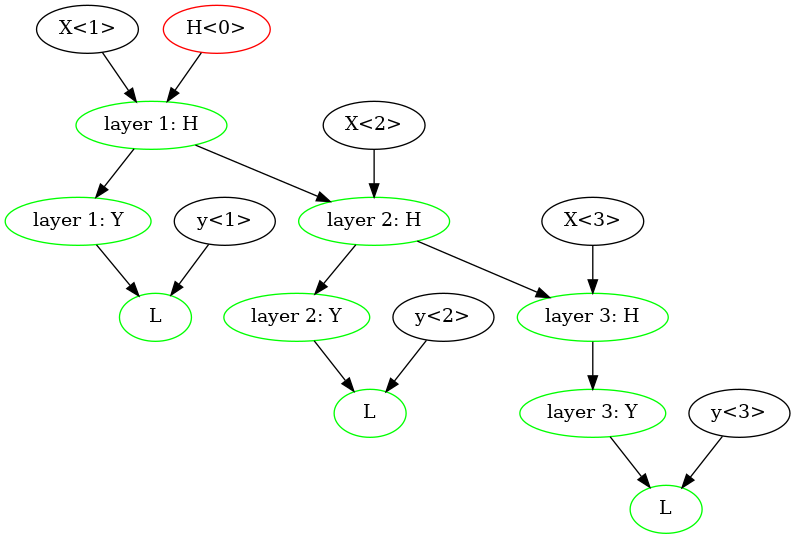

In [5]:
Show(g,300)